# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры, но не менее 0.59. 

## Подготовка данных

Загрузим необходимые библиотеки.

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from joblib import dump

Теперь посмотрим банковскую базу данных.

In [ ]:
try:
    data = pd.read_csv('Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Итак,  10 тысяч строк и четырнадцать колонок, из которых колонка "Exited" является целевым признаком. Кроме того, колонки "RowNumber", "Surname" и "CustomerId" не имеют никакого значения для построения моделей и мы их можем удалить (более того, кажется, эти столбцы могут помещать модели работать корректно).

In [ ]:
df = data.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)

Посмотрим состав данных.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


В таблице почти 1000 пропусков в столбце "Tenure". Учитывая тот факт, что данный показатель является достаточно важным при характеристике клиента банка, а так же тот факт, что других пропусков нет, предположу, что эти пропуски связаны с тем фактом, что клиенты сотрудничают с банком менее года. Заменим пропуски значением 0.

In [ ]:
df['Tenure'] = df['Tenure'].fillna(0)

Кроме того, мы имеем два столбца с категоральными данными, которые следует перевести в числовые методом "One-Hot Encoding" (OHE).

In [ ]:
df_ohe = pd.get_dummies(df, drop_first=False) #Данных не очень много. Думаю нет смысла удалять первый столбец.

И посмотрим.

In [ ]:
df_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,1,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,1,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,1,0,0,1,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,0,1,0,0,1


Можно переходить к исследованию задачи.

## Исследование задачи

Разделим выборку методом train_test_split.

Сначала отделим тестовую выборку от общего датасета в размере 20%

In [ ]:
df_train, df_test = train_test_split(df_ohe, test_size=0.20, random_state=12345)

От 10 тысяч строк 20% будет 2000 строк - тестовая выборка.

Затем отделим от тренировочной (оставшиеся 8000) 25% для валидационной выборки, что так же составит 2000 строк.

Таким образом получим соотношение 3:1:1

In [ ]:
target = df_train['Exited']
features = df_train.drop('Exited', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

Подберем лучшую модель.

### Решающее дерево

Обучим решающее дерево на тренировачном фрейме и посмотрим его аккуратность меняя уровень глубины дерева от 1 до 15

In [ ]:
for depth in range(1,16): 
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid)) 


max_depth = 1 : 0.8045
max_depth = 2 : 0.8325
max_depth = 3 : 0.843
max_depth = 4 : 0.85
max_depth = 5 : 0.855
max_depth = 6 : 0.857
max_depth = 7 : 0.8575
max_depth = 8 : 0.849
max_depth = 9 : 0.842
max_depth = 10 : 0.8395
max_depth = 11 : 0.8275
max_depth = 12 : 0.824
max_depth = 13 : 0.812
max_depth = 14 : 0.8155
max_depth = 15 : 0.8115


За лучший вариант возьмем модель с глубиной дерева - 7.

Попробуем найти F-1 меру, так как по условиям задачи, нам необходимо довести эту меру до показателя не менее 0,59.

In [ ]:
model = DecisionTreeClassifier(max_depth = 7, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.5511811023622046


0,55 меньше чем необходимо.

Чтобы выявить, как сильно полученная модель отличается от случайной, найдем значение AUC-ROC.

In [ ]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8300933527679184


Показатель AUC-ROC превышает показатели константной модели соответствующей 0,5. Модель работает корректно.

### Случайный лес

Попробуем обучить модель используя 'случайный лес' с числом деревьев до 15.

In [ ]:
best_model = None
best_result = 0
for est in range(1, 16):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(features_train, target_train) 
    result = model.score(features_valid, target_valid) 
    if result > best_result:
        best_model = model
        best_result = result 

print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Лучшая модель на валидационной выборке:", best_model)

Accuracy наилучшей модели на валидационной выборке: 0.8505
Лучшая модель на валидационной выборке: RandomForestClassifier(n_estimators=14, random_state=12345)


Метрика Accuracy чуть ниже чем у решающего древа.

Определим меру f-1.

In [ ]:
model = RandomForestClassifier(n_estimators=15, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.5331278890600923


Мера f-1 выше чем у решающего древа, однако, не дотягивает до необходимой величины.

AUC-ROC.

In [ ]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8145986689322688


Показатель AUC-ROC превышает показатели константной модели соответствующей 0,5. Модель работает корректно.

### Логистическая регрессия

Обучим модель использую логистическую регрессию. Возьмем базовый алгоритм 'lbfgs', а колличество итераций обучения - 1000.

In [ ]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model.fit(features_train, target_train) 
predictions = model.predict(features_valid)
print("Accuracy модели на валидационной выборке:", model.score(features_valid, target_valid))

Accuracy модели на валидационной выборке: 0.7995


f1 мера.

In [ ]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.10290827740492169


Видимо где-то ошибся. Не верю, что f-1 может быть настолько низким

AUC-ROC.

In [ ]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.6811032570944447


Показатель AUC-ROC превышает показатели константной модели соответствующей 0,5. Модель работает корректно.

## Борьба с дисбалансом

Судя по исходному датафрейму, столбцы с числовыми значениями (такие как "Age", "Balance", "EstimatedSalary") могут иметь дисбаланс классов.

38    407
35    385
37    378
36    359
34    356
     ... 
82      1
85      1
92      1
88      1
80      1
Name: Age, Length: 69, dtype: int64

<AxesSubplot:>

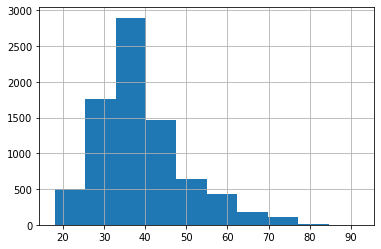

In [ ]:
display(features['Age'].value_counts())
features['Age'].hist()


Логично, большая часть клиентов имеет возраст от25 до 45 лет, в то время как клиенты старше 70 лет встречаются крайне редко.

0.00         2911
105473.74       2
115115.38       1
130181.47       1
165969.26       1
             ... 
145081.73       1
125724.95       1
117866.92       1
131736.88       1
206014.94       1
Name: Balance, Length: 5089, dtype: int64

<AxesSubplot:>

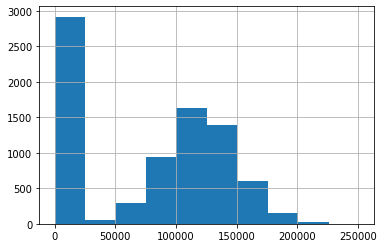

In [ ]:
display(features['Balance'].value_counts())
features['Balance'].hist()

Здесь так же значительный дисбаланс, так как около трех тысяч клиентов практически не имеют никаких сбережений на счетах банка.

109145.20    1
79580.56     1
170705.53    1
172149.76    1
188809.23    1
            ..
91957.39     1
69056.26     1
158610.89    1
150757.35    1
155061.97    1
Name: EstimatedSalary, Length: 8000, dtype: int64

<AxesSubplot:>

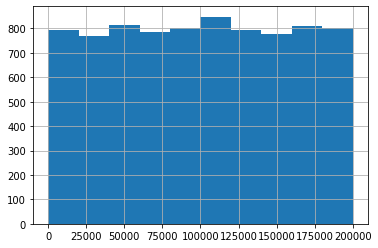

In [ ]:
display(features['EstimatedSalary'].value_counts())
features['EstimatedSalary'].hist()

С зарплатой я ошибся, так как классы здесь сбалансированы.

Придадим объектам редкого класса больший вес.


Добавим в каждую из моделей аргумент class_weight и посмотрим как изменится мера f-1.

### Решающее дерево.

In [ ]:
for depth in range(1,20): 
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print("F1 balanced:", f1_score(target_valid, predicted_valid))


max_depth = 1 : F1 balanced: 0.4750733137829912
max_depth = 2 : F1 balanced: 0.49761677788369874
max_depth = 3 : F1 balanced: 0.49761677788369874
max_depth = 4 : F1 balanced: 0.5170454545454546
max_depth = 5 : F1 balanced: 0.5489078822412156
max_depth = 6 : F1 balanced: 0.5571428571428572
max_depth = 7 : F1 balanced: 0.5549845837615621
max_depth = 8 : F1 balanced: 0.5488958990536278
max_depth = 9 : F1 balanced: 0.5266331658291458
max_depth = 10 : F1 balanced: 0.5050301810865191
max_depth = 11 : F1 balanced: 0.5077605321507761
max_depth = 12 : F1 balanced: 0.49723756906077354
max_depth = 13 : F1 balanced: 0.4965197215777262
max_depth = 14 : F1 balanced: 0.4861111111111111
max_depth = 15 : F1 balanced: 0.47757575757575754
max_depth = 16 : F1 balanced: 0.47250000000000003
max_depth = 17 : F1 balanced: 0.47655259822560203
max_depth = 18 : F1 balanced: 0.47483870967741937
max_depth = 19 : F1 balanced: 0.4660691421254802


Лучший результат при глубине - 6. Хотя Accuracy показатель снизился по сравнению с несбалансированной моделью.

Перепроверим f-1 меру

In [ ]:
model = DecisionTreeClassifier(max_depth = 6, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.5571428571428572



Желаемого результата нет.

Попробуем увеличить выборку с количеством повторений.

Посмотрим матрицу ошибок, чтобы сравнить количество положительных и отрицательных решений.

In [ ]:
print(confusion_matrix(target_valid, predicted_valid))

[[1293  316]
 [ 118  273]]


Отрицательных больше примерно в 4 раза. Исходя из этого увеличим долю положительных ответов в выборке.

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

for depth in range(1,20): 
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print("F1 balanced:", f1_score(target_valid, predicted_valid)) 
#model = DecisionTreeClassifier(random_state=12345)
#model.fit(features_upsampled, target_upsampled)
#predicted_valid = model.predict(features_valid)

#print("F1:", f1_score(target_valid, predicted_valid))

max_depth = 1 : F1 balanced: 0.4750733137829912
max_depth = 2 : F1 balanced: 0.49761677788369874
max_depth = 3 : F1 balanced: 0.49761677788369874
max_depth = 4 : F1 balanced: 0.5170454545454546
max_depth = 5 : F1 balanced: 0.5489078822412156
max_depth = 6 : F1 balanced: 0.5571428571428572
max_depth = 7 : F1 balanced: 0.5564681724845996
max_depth = 8 : F1 balanced: 0.547945205479452
max_depth = 9 : F1 balanced: 0.5241935483870969
max_depth = 10 : F1 balanced: 0.5025227043390514
max_depth = 11 : F1 balanced: 0.5060240963855421
max_depth = 12 : F1 balanced: 0.49504950495049516
max_depth = 13 : F1 balanced: 0.49766355140186913
max_depth = 14 : F1 balanced: 0.4749708963911525
max_depth = 15 : F1 balanced: 0.4829268292682927
max_depth = 16 : F1 balanced: 0.48180677540777916
max_depth = 17 : F1 balanced: 0.48662420382165605
max_depth = 18 : F1 balanced: 0.458974358974359
max_depth = 19 : F1 balanced: 0.4675324675324675


Перепроверим.

In [ ]:
model = DecisionTreeClassifier(max_depth = 6, random_state=12345, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1 balanced:", f1_score(target_valid, predicted_valid))

F1 balanced: 0.5571428571428572


Результата нет.

Теперь уменьшим.

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

for depth in range(1,20): 
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print("F1 balanced:", f1_score(target_valid, predicted_valid)) 


max_depth = 1 : F1 balanced: 0.4750733137829912
max_depth = 2 : F1 balanced: 0.49761677788369874
max_depth = 3 : F1 balanced: 0.5118376550169109
max_depth = 4 : F1 balanced: 0.49569377990430613
max_depth = 5 : F1 balanced: 0.5327659574468085
max_depth = 6 : F1 balanced: 0.5405405405405406
max_depth = 7 : F1 balanced: 0.544776119402985
max_depth = 8 : F1 balanced: 0.5136921624173748
max_depth = 9 : F1 balanced: 0.502835538752363
max_depth = 10 : F1 balanced: 0.48847926267281105
max_depth = 11 : F1 balanced: 0.4894837476099426
max_depth = 12 : F1 balanced: 0.4822565969062785
max_depth = 13 : F1 balanced: 0.4921369102682702
max_depth = 14 : F1 balanced: 0.4910714285714286
max_depth = 15 : F1 balanced: 0.47907390917186116
max_depth = 16 : F1 balanced: 0.4884547069271759
max_depth = 17 : F1 balanced: 0.4767747589833479
max_depth = 18 : F1 balanced: 0.4750219106047327
max_depth = 19 : F1 balanced: 0.4828193832599119


Перепроверим лучший показатель

In [ ]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7, class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.544776119402985


Снова мимо.

### Случайный лес.

Повторим теже процедуры с RandomForestClassifier

Найдем лучшие гиперпараметры с учетом балансирования классов.

In [ ]:
best_model = None
best_result = 0
for est in range(1, 30):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced') 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_model = model
        best_result = result 

print("F1 balanced лучшей модели:", f1_score(target_valid, predicted_valid))
print("Лучшая модель на валидационной выборке:", best_model)

F1 balanced лучшей модели: 0.5659777424483307
Лучшая модель на валидационной выборке: RandomForestClassifier(class_weight='balanced', n_estimators=29,
                       random_state=12345)


Перепроверим f-1 мера.

In [ ]:
model = RandomForestClassifier(n_estimators=29, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.5659777424483307


Опять мимо.

Увеличим выборку и найдем f-1

In [ ]:
best_model = None
best_result = 0
for est in range(1, 30):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced') 
    model.fit(features_upsampled, target_upsampled) 
    predicted_valid = model.predict(features_valid)
    #result = model.score(features_valid, target_valid) 
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result 

print("F1 balanced лучшей модели:", best_result)
print("Лучшая модель на валидационной выборке:", best_model)

F1 balanced лучшей модели: 0.5834464043419267
Лучшая модель на валидационной выборке: RandomForestClassifier(class_weight='balanced', n_estimators=27,
                       random_state=12345)


Уже близко, но по прежнему мимо.



Попробую добавить максимальную глубину.

In [ ]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 30):
    for depth in range (1, 30):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced') 
        model.fit(features_upsampled, target_upsampled) 
        predicted_valid = model.predict(features_valid) 
        result = f1_score(target_valid, predicted_valid) 
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("F1  лучшей модели:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

F1  лучшей модели: 0.6023778071334214 Количество деревьев: 23 Максимальная глубина: 29


Очень медленно, однако, есть результат!!!

Перепроверим гиперпараметры

In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=23, max_depth=29, class_weight='balanced')
model.fit(features_upsampled, target_upsampled) 
predicted_valid = model.predict(features_valid) 

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5599999999999999


<div class="alert alert-block alert-info">Теперь уменьшим.

In [ ]:
best_model = None
best_result = 0
for est in range(1, 50):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced') 
    model.fit(features_downsampled, target_downsampled) 
    result = model.score(features_valid, target_valid) 
    if result > best_result:
        best_model = model
        best_result = result 

print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Лучшая модель на валидационной выборке:", best_model)

Accuracy наилучшей модели на валидационной выборке: 0.7765
Лучшая модель на валидационной выборке: RandomForestClassifier(class_weight='balanced', n_estimators=2,
                       random_state=12345)


In [ ]:
model = RandomForestClassifier(n_estimators=2, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4467836257309942


Результата нет.

### Логистическая регрессия

 Провел данные процедуры выше.

Пробуем.

In [ ]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.43373493975903615


Увеличим

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.43373493975903615


Уменьшим

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000, class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.43471337579617836


### Предварительный вывод.

<div class="alert alert-block alert-info">После проведенных экспериментов, лучшая модель на валидационной выборке по f-1 мере: RandomForestClassifier(n_estimators=23, random_state=12345, max_depth=29) с увеличенной выборкой по положительным ответам с количеством повторений - 4, c балансированием классов.

## Тестирование модели

Для тестирования полученной модели посчитаем коэффициет детерминации (R2) на тестовой и валидационной выборках.

In [ ]:
model = RandomForestClassifier(n_estimators=23, random_state=12345)
model.fit(features_upsampled, target_upsampled)

print("Наилучшая модель")
print("R2 на обучающей выборке: ", model.score(features_train, target_train)) 
print("R2 на валидационной выборке: ", model.score(features_valid, target_valid)) 

Наилучшая модель
R2 на обучающей выборке:  0.9998333333333334
R2 на валидационной выборке:  0.852


Разница между валидационной и тестовой выборкой минимальная, показатель R2 достаточно высокий, что говорит о корректной работе модели.

Проверим полученную модель на тествовой выборке.

In [ ]:
target_test = df_test['Exited']
features_test = df_test.drop('Exited', axis=1)
model = RandomForestClassifier(n_estimators=23, random_state=12345, class_weight='balanced', max_depth=29)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))

F1: 0.5947302383939774


 Есть необходимый результат!!!!

## Вывод

<div class="alert alert-block alert-info">
<font size="4">Исследовав три модели обучения данных я пришел к выводу, что для прогноза поведения клиентов банка, а именно их желания уйти из банка в ближайшее время, наиболее успешной моделью предсказания по f-1 мере стала модель - "Случайный лес" с количеством деревьев - 23, глубиной - 29 и обязательным балансом классов. Кроме того, учитывая значительный перекос в целевых показателях (столбец "Exited") в отрицательную сторону, для обучения модели было принято решение увеличить, а затем перемешать тренировочную выборку создав баланс целевых признаков.